### Notebook for Vincent to create visualization / test code 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import clustering as cl
import util
import healpy as hp
import importlib as imp
from collections import defaultdict
import seaborn as sns 
from time import time
import visual

%matplotlib inline 

In [2]:
# Global parameters
gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

nside=8
n = -14
dt=15.0
cr=0.00124
pixels=range(hp.nside2npix(nside))

train_path = 'demo_train/UnnObs_Training_1_line_A_ec_labelled_2457308.5_pm15.0_r2.5.trans'
itf_path = 'demo_itf/itf_new_1_line_ec_2457308.5_pm15.0_r2.5.trans'


In [3]:
tr_results, tr_clust_ids = cl.find_clusters([281], train_path, util.lunation_center(n), g_gdots=g_gdots,dt=dt,rad=cr)

Starting run...
100%

Run finished!


In [4]:
res_dict = cl.get_res_dict(train_path,[281],nside,n)[281]

In [5]:
agg_dict = defaultdict(list)
for k,v in tr_clust_ids.items():
    # k is the tracklet id, v is the cluster id 
    if res_dict[k]!=[]:
        agg_dict[v].append([tuple([k]+list(i)) for i in res_dict[k]])

1.0
428, 3


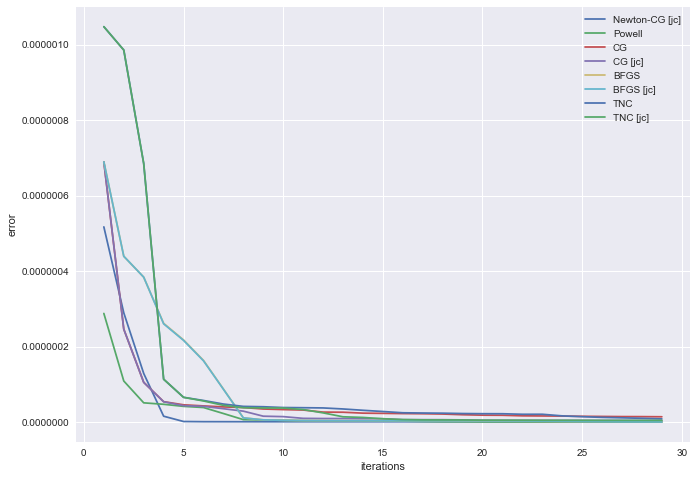

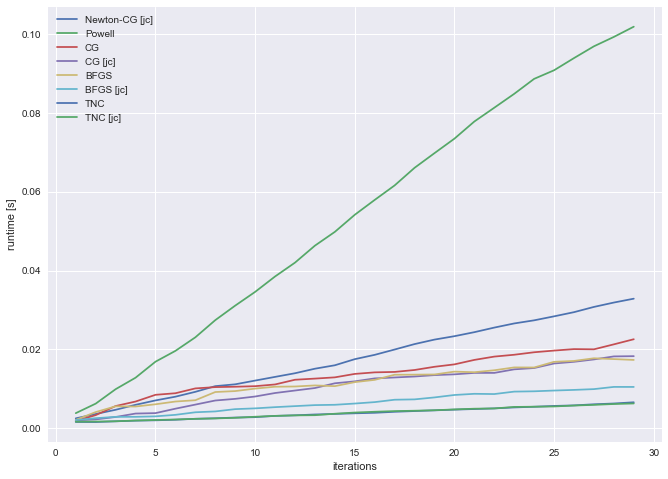

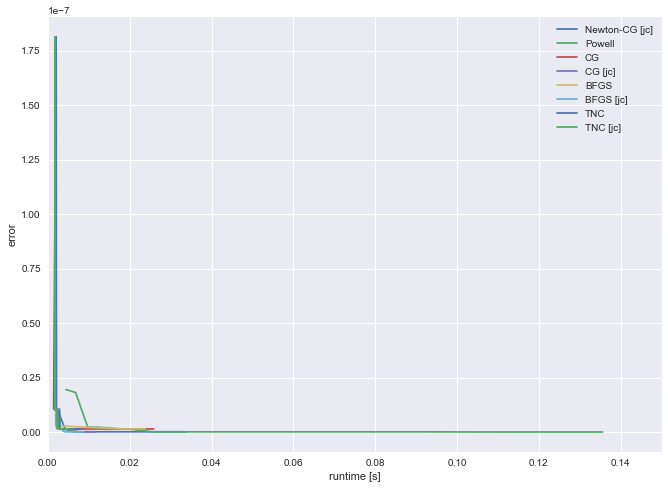

In [56]:
g,gdot = 0.4,0.0
cl = imp.reload(cl)
import time
from IPython.display import clear_output

#idx = 2360

    #special requirements:
    #Hessian for Newton-CG
    #Jacobian AND Hessian for dogleg
    #Jacobian AND Hessian for trust-ncg

legend = []

#the solvers to evaluate.
solvers = ['Newton-CG', 'Powell','CG','BFGS','TNC']#'Newton-CG',Nelder-Mead','Powell','CG','BFGS','L-BFGS-B','TNC','COBYLA','SLSQP','dogleg','trust-ncg']

#the iteration range to test.
xrange = range(1,30) #1,50

#maximum number of clusters to re-fit
test_num = 50 #float('inf')


plt.figure(1, figsize = (11,8))
plt.figure(2, figsize = (11,8))
plt.figure(3, figsize = (11,8))

for solver in solvers:
    print('running ' + solver)

    for use_jc in [False, True]:
        if use_jc and (solver=='Nelder-Mead' or solver=='Powell' or solver=='COBYLA'): continue #these solvers can not make use of the jacobian
        if not use_jc and (solver=='dogleg' or solver=='trust-ncg' or solver=='Newton-CG'): continue #these solvers explicitly require jacobians, so skip those
        
        yvals = np.zeros(len(xrange))
        yvals_time = np.zeros(len(xrange))
        total_tests = 0
        #evaluate solver with option use_jc on all clusters
        processed=0
        for idx in agg_dict:
            if len(agg_dict[idx])==0: continue #skip this one
            processed+=1
            if processed>test_num:
                break
            clear_output(True)
            print(processed/min(len(agg_dict),test_num))
            print(str(idx) + ', ' + str(len(agg_dict[idx])))
            total_tests+=1
            time_err = []
            ct=0
            for max_iter in xrange:
                start = time.clock()
                returns = cl.full_fit_t_loss(util.lunation_center(n), g, gdot, agg_dict[idx], details=True,  method=solver, use_jacobian=use_jc, force_itercount=max_iter)
                if returns==None:
                    continue
                time_elapsed = time.clock()-start
                yvals_time[ct]+=time_elapsed

                params = returns[0]
                loss_val = returns[1]
                chisq = returns[2]
                chisq_arr = returns[3]

                time_err.append([time_elapsed, loss_val])

                iters = returns[4]
                num_evals = returns[5]
                num_evals_j = returns[6]
                num_evals_h = returns[7]
                #print('solver ' + str(solver) + ": loss = " + str(loss_val) + ', iters = ' + str(iters) + ', num_evals = ' + str(num_evals))
                yvals[ct]+=loss_val
                ct+=1

        yvals/=total_tests
        yvals_time/=total_tests
        time_err = list(sorted(time_err))
        time_err = np.array(time_err)
        res = plt.figure(1)
        res = plt.plot(xrange, yvals)
        res = plt.figure(2)
        res = plt.plot(xrange, yvals_time)
        res = plt.figure(3)
        res = plt.plot(time_err[:,0], time_err[:,1])

        legend.append(solver + (' [jc]' if use_jc else ''))

            #break

res = plt.figure(1)
res = plt.legend(legend)
res = plt.xlabel('iterations')
res = plt.ylabel('error')

res = plt.figure(2)
res = plt.legend(legend)
res = plt.xlabel('iterations')
res = plt.ylabel('runtime [s]')

res = plt.figure(3)
res = plt.legend(legend)
res = plt.xlabel('runtime [s]')
res = plt.ylabel('error')
res = plt.xlim([0,0.15])